# [Ridge Classification (Least Squares Support Vector Machines)](https://scikit-learn.org/stable/modules/linear_model.html#classification)

This classifier first converts binary targets to {-1, 1} and then treats the problem as a regression task, optimizing the same objective as above. The predicted class corresponds to the sign of the regressor’s prediction.

It might seem questionable to use a (penalized) Least Squares loss to fit a classification model instead of the more traditional logistic or hinge losses. However, in practice, all those models can lead to similar cross-validation scores in terms of accuracy or precision/recall, while the penalized least squares loss used by the RidgeClassifier allows for a very different choice of the numerical solvers with distinct computational performance profiles.

The RidgeClassifier can be significantly faster than e.g. LogisticRegression with a high number of classes because it can compute the projection matrix $ (X^{T}X)^{-1}X^{T}$ only once.

## [Classification of text documents using sparse features](https://scikit-learn.org/stable/auto_examples/text/plot_document_classification_20newsgroups.html#classification-of-text-documents-using-sparse-features)

This is an example showing how scikit-learn can be used to classify documents by topics using a [Bag of Words](https://en.wikipedia.org/wiki/Bag-of-words_model) approach. This example uses a Tf-idf-weighted document-term sparse matrix to encode the features and demonstrates various classifiers that can efficiently handle sparse matrices.

### Load 20 newspaper data and pre process it

In [5]:
from time import time

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer

categories = [
    "alt.atheism",
    "talk.religion.misc",
    "comp.graphics",
    "sci.space",
]

def size_mb(docs):
    return sum(len(s.encode("utf-8")) for s in docs) / 1e6


def load_dataset(verbose=False, remove=()):
    """Load and vectorize the 20 newsgroups dataset."""

    data_train = fetch_20newsgroups(
        subset="train",
        categories=categories,
        shuffle=True,
        random_state=42,
        remove=remove,
    )

    data_test = fetch_20newsgroups(
        subset="test",
        categories=categories,
        shuffle=True,
        random_state=42,
        remove=remove,
    )

    # order of labels in `target_names` can be different from `categories`
    target_names = data_train.target_names

    # split target in a training set and a test set
    y_train, y_test = data_train.target, data_test.target

    # Extracting features from the training data using a sparse vectorizer
    t0 = time()
    vectorizer = TfidfVectorizer(
        sublinear_tf=True, max_df=0.5, min_df=5, stop_words="english"
    )
    X_train = vectorizer.fit_transform(data_train.data)
    duration_train = time() - t0

    # Extracting features from the test data using the same vectorizer
    t0 = time()
    X_test = vectorizer.transform(data_test.data)
    duration_test = time() - t0

    feature_names = vectorizer.get_feature_names_out()

    if verbose:
        # compute size of loaded data
        data_train_size_mb = size_mb(data_train.data)
        data_test_size_mb = size_mb(data_test.data)

        print(
            f"{len(data_train.data)} documents - "
            f"{data_train_size_mb:.2f}MB (training set)"
        )
        print(f"{len(data_test.data)} documents - {data_test_size_mb:.2f}MB (test set)")
        print(f"{len(target_names)} categories")
        print(
            f"vectorize training done in {duration_train:.3f}s "
            f"at {data_train_size_mb / duration_train:.3f}MB/s"
        )
        print(f"n_samples: {X_train.shape[0]}, n_features: {X_train.shape[1]}")
        print(
            f"vectorize testing done in {duration_test:.3f}s "
            f"at {data_test_size_mb / duration_test:.3f}MB/s"
        )
        print(f"n_samples: {X_test.shape[0]}, n_features: {X_test.shape[1]}")

    return X_train, X_test, y_train, y_test, feature_names, target_names

### Model without metadata stripping

#### Load the newspaper data with the metadata intact

In [6]:
X_train, X_test, y_train, y_test, feature_names, target_names = load_dataset(verbose=True)

2034 documents - 3.98MB (training set)
1353 documents - 2.87MB (test set)
4 categories
vectorize training done in 0.186s at 21.439MB/s
n_samples: 2034, n_features: 7831
vectorize testing done in 0.117s at 24.573MB/s
n_samples: 1353, n_features: 7831


#### Use the `Ridge Classifier` for prediction and plot results

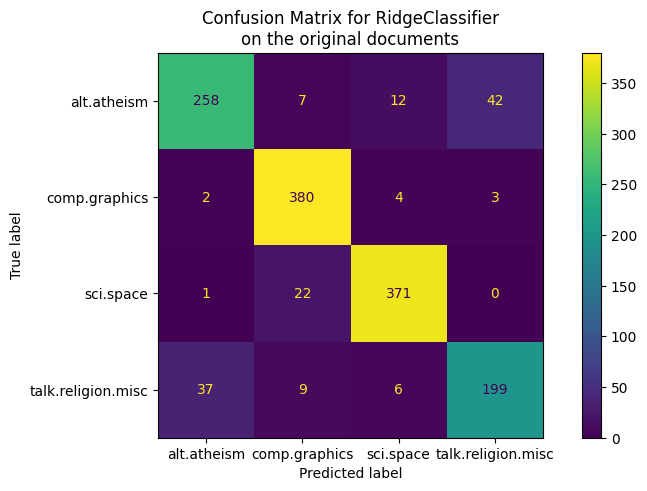

In [7]:
from sklearn.linear_model import RidgeClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

clf = RidgeClassifier(tol=1e-2, solver="sparse_cg")
clf.fit(X_train, y_train)
pred = clf.predict(X_test)


# We plot the confusion matrix of this classifier to find if there is a pattern in the classification errors.
fig, ax = plt.subplots(figsize=(10, 5))
ConfusionMatrixDisplay.from_predictions(y_test, pred, ax=ax)
ax.xaxis.set_ticklabels(target_names)
ax.yaxis.set_ticklabels(target_names)
_ = ax.set_title(
    f"Confusion Matrix for {clf.__class__.__name__}\non the original documents"
)

#### Deeper understanding of the classifier results using the highest average feature effects

top 5 keywords per class:
  alt.atheism comp.graphics sci.space talk.religion.misc
0       keith      graphics     space          christian
1         god    university      nasa                com
2    atheists        thanks     orbit                god
3      people          does      moon           morality
4     caltech         image    access             people


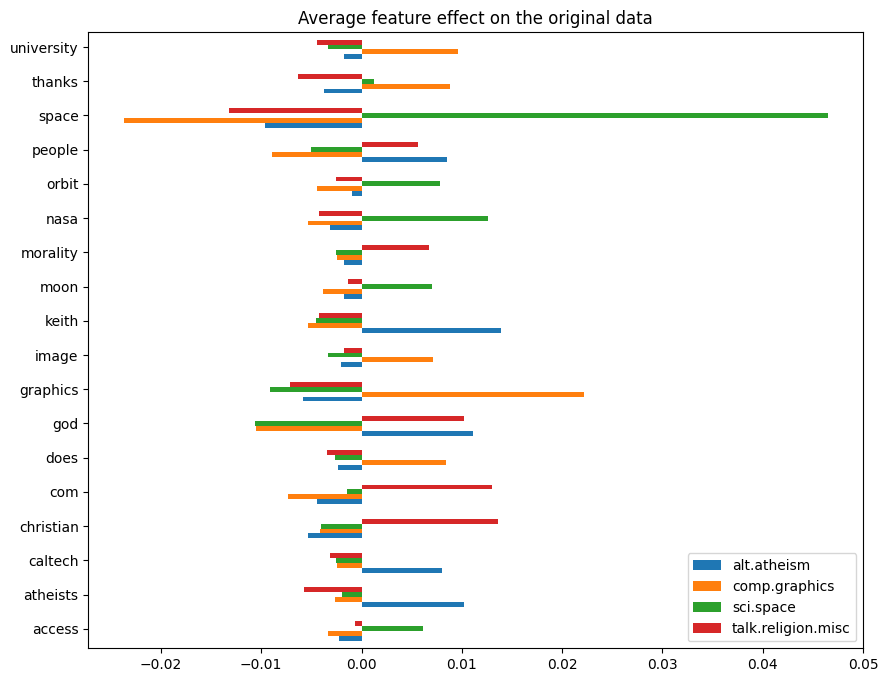

In [9]:
import numpy as np
import pandas as pd


def plot_feature_effects():
    # learned coefficients weighted by frequency of appearance
    average_feature_effects = clf.coef_ * np.asarray(X_train.mean(axis=0)).ravel()

    for i, label in enumerate(target_names):
        top5 = np.argsort(average_feature_effects[i])[-5:][::-1]
        if i == 0:
            top = pd.DataFrame(feature_names[top5], columns=[label])
            top_indices = top5
        else:
            top[label] = feature_names[top5]
            top_indices = np.concatenate((top_indices, top5), axis=None)
    top_indices = np.unique(top_indices)
    predictive_words = feature_names[top_indices]

    # plot feature effects
    bar_size = 0.25
    padding = 0.75
    y_locs = np.arange(len(top_indices)) * (4 * bar_size + padding)

    fig, ax = plt.subplots(figsize=(10, 8))
    for i, label in enumerate(target_names):
        ax.barh(
            y_locs + (i - 2) * bar_size,
            average_feature_effects[i, top_indices],
            height=bar_size,
            label=label,
        )
    ax.set(
        yticks=y_locs,
        yticklabels=predictive_words,
        ylim=[
            0 - 4 * bar_size,
            len(top_indices) * (4 * bar_size + padding) - 4 * bar_size,
        ],
    )
    ax.legend(loc="lower right")

    print("top 5 keywords per class:")
    print(top)

    return ax

_ = plot_feature_effects().set_title("Average feature effect on the original data")

We can observe that the most predictive words are often strongly positively associated with a single class and negatively associated with all the other classes.
Notice however that there are also words such as "christian" and "morality" that are only positively associated with "talk.misc.religion".

### Model with metadata stripping

The `remove` option of the 20 newsgroups dataset loader in scikit-learn allows to heuristically attempt to filter out some of this unwanted metadata that makes the classification problem artificially easier. Be aware that such filtering of the text contents is far from perfect.

top 5 keywords per class:
  alt.atheism comp.graphics sci.space talk.religion.misc
0         don      graphics     space                god
1      people          file      like          christian
2         say        thanks      nasa              jesus
3    religion         image     orbit         christians
4        post          does    launch              wrong


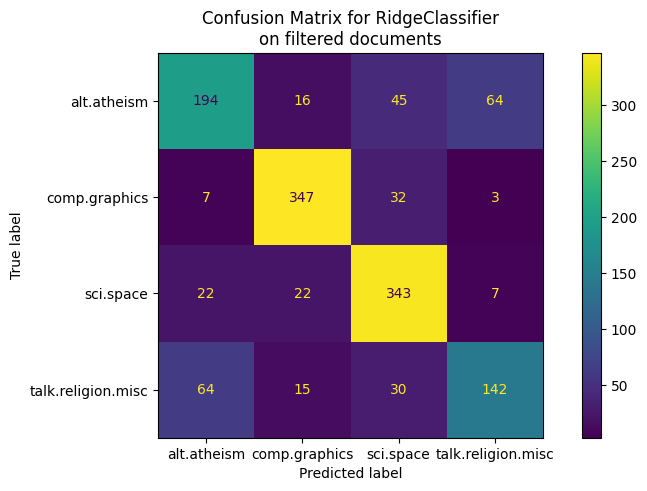

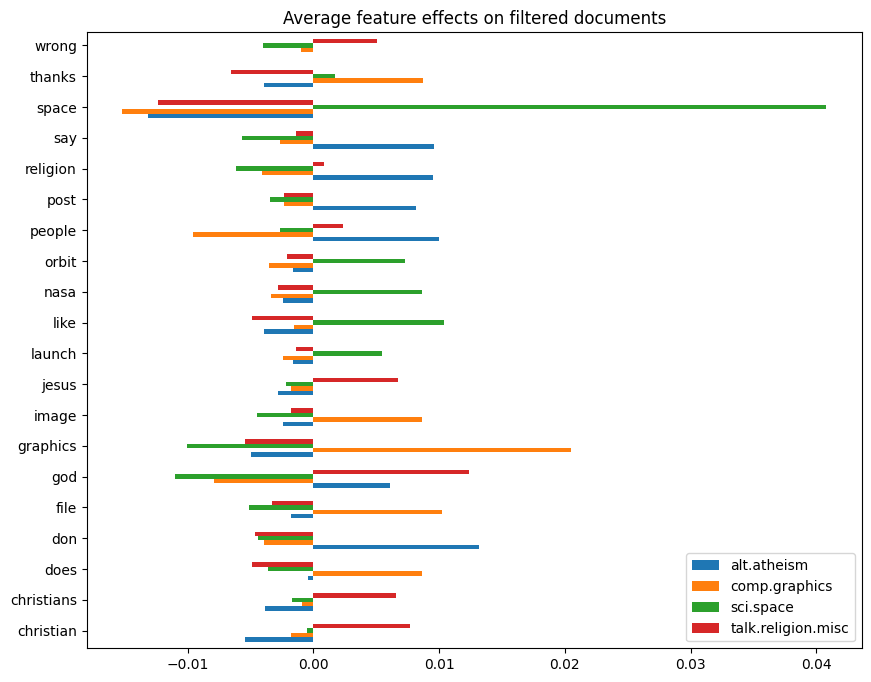

In [13]:
(
    X_train,
    X_test,
    y_train,
    y_test,
    feature_names,
    target_names,
) = load_dataset(remove=("headers", "footers", "quotes"))

clf = RidgeClassifier(tol=1e-2, solver="sparse_cg")
clf.fit(X_train, y_train)
pred = clf.predict(X_test)

fig, ax = plt.subplots(figsize=(10, 5))
ConfusionMatrixDisplay.from_predictions(y_test, pred, ax=ax)
ax.xaxis.set_ticklabels(target_names)
ax.yaxis.set_ticklabels(target_names)
_ = ax.set_title(
    f"Confusion Matrix for {clf.__class__.__name__}\non filtered documents"
)

_ = plot_feature_effects().set_title("Average feature effects on filtered documents")
